<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import torch
  import torchvision
  # check torch 0.12+
  assert(torch.__version__.split('.')[1] >= 12)
  # check torchvision 0.13+
  assert(torchvision.__version__.split('.') >= 13)
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  # install latest torch and torchvision
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# import torchinfo or download if necessary
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

# import third party scripts or download from repo if necessary
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    # clone repo
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    # move files from repo to current directory
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    # remove repo -r=recursive, -f=force
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3416, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 3416 (delta 47), reused 90 (delta 38), pack-reused 3302
Receiving objects: 100% (3416/3416), 643.45 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (1954/1954), done.
Updating files: 100% (222/222), done.


In [3]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# download third party data and extract to data/pizza_steak_sushi
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [5]:
# store file paths for training and test image folders
train_folder = image_path / "train"
test_folder = image_path / "test"

In [6]:
# transform to resize images to 224 x 224 for ViT and convert to tensor
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [7]:
import os

# create data loaders
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_folder,
                                                                           test_dir=test_folder,
                                                                           transform=transform,
                                                                           batch_size=BATCH_SIZE,
                                                                           num_workers=os.cpu_count())

image shape: torch.Size([3, 224, 224])


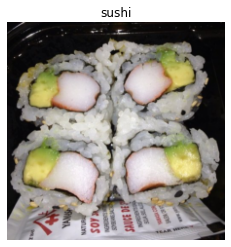

In [8]:
# get next batch of images and labels
batch_images, batch_labels = next(iter(train_dataloader))
# get first image and label from batch
image, label = batch_images[0], batch_labels[0]

# display image and label
print(f"image shape: {image.shape}")
# move color channel for matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False); # semicolon used to supress output in notebooks

### Patch embeddings

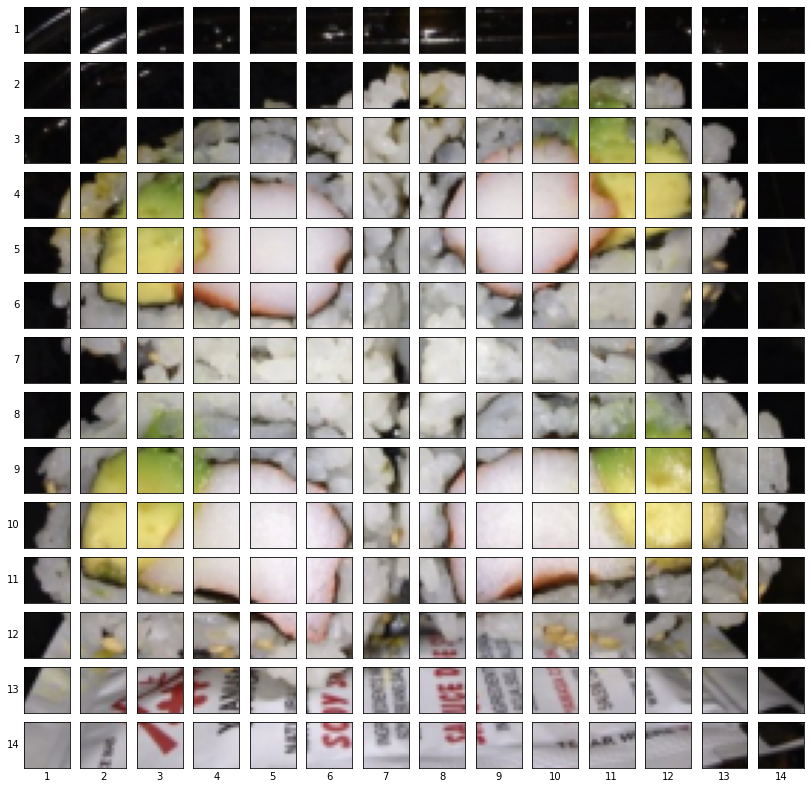

In [9]:
# split image into 16x16 patches

# move color channel for matplotlib
matplot_image = image.permute(1, 2, 0)

# dimensions of image
img_width = 224
img_height = 224
# size of patches
patch_size = 16
# number of patches in width or heght of image
num_patches = 224 / 16
assert(img_width % patch_size == 0)

# subplot for plotting every patch in image
fig, ax = plt.subplots(nrows=img_height // patch_size, ncols=img_width // patch_size, figsize=(num_patches, num_patches), sharex=True, sharey=True)

# for each patch in the height of the image
for i, row_patch in  enumerate(range(0, img_height, patch_size)):
  # for each patch in the row of the image
  for j, col_patch in enumerate(range(0, img_width, patch_size)):
    # add the current patch of the image to the subplot
    ax[i,j].imshow(matplot_image[row_patch:row_patch+patch_size, col_patch:col_patch+patch_size, :])
    # set the position of axes labels
    ax[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center") 
    ax[i, j].set_xlabel(j+1) 
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    # only show labels on the first column and last row of subplots
    ax[i, j].label_outer()

### Convolution layer

convolution output: torch.Size([1, 768, 14, 14])


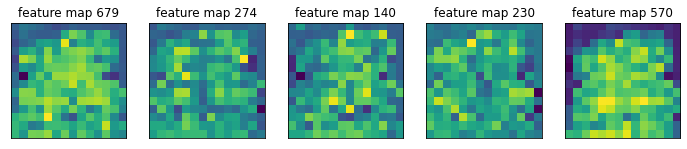

In [10]:
import random

# define convolution layer
layer_1 = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=(patch_size, patch_size), stride=patch_size, padding=0)
# convolve image
feature_map_tensor = layer_1(image.unsqueeze(dim=0))
# convolution output shape
print(f"convolution output: {feature_map_tensor.shape}")

# display 5 random feature maps
rand_idx = random.sample(range(0, 768), k=5)

# set up figure to show the five feature maps
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(rand_idx):
  # display the random feature map from the convolution output
  feature_map = feature_map_tensor[:, idx, :, :]
  ax[i].imshow(feature_map.squeeze().detach().numpy())
  ax[i].set_title(f"feature map {idx}")
  ax[i].set_xticks([])
  ax[i].set_yticks([])


torch.Size([1, 196, 768])


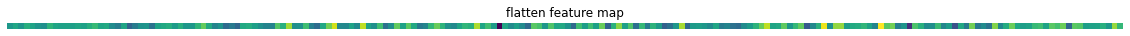

In [11]:
# flatten feature maps
layer_2 = nn.Flatten(start_dim=2, end_dim=3)
feature_map_tensor = layer_2(feature_map_tensor)
# move the feature map dimension
feature_map_tensor = feature_map_tensor.permute(0, 2, 1)

print(feature_map_tensor.shape)

plt.figure(figsize=(20,20))
plt.imshow(feature_map_tensor.detach().numpy()[:, :, 0])
plt.title(f"flatten feature map")
plt.axis(False);

In [12]:
# create custom patch embedding layer
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, embedding_size=768, patch_size=16):
    super(PatchEmbedding, self).__init__()
    self.in_channels = in_channels
    self.embedding_size = embedding_size
    self.patch_size = patch_size
    self.embedding = nn.Sequential(
        nn.Conv2d(in_channels=self.in_channels, out_channels=self.embedding_size, kernel_size=self.patch_size, stride=self.patch_size, padding=0),
        nn.Flatten(start_dim=2, end_dim=3)
    )

  def forward(self, x):
    # check dimension of input
    assert(x.shape[-1] % self.patch_size == 0)
    # convole input and flatten
    output = self.embedding(x)
    # swap embedding and patch dimensions
    return output.permute(0, 2, 1)

In [13]:
# apply patch embedding layer
embedding_layer = PatchEmbedding()
output = embedding_layer(image.unsqueeze(dim=0))

### Class Token

In [14]:
print(output)
print(output.shape)

tensor([[[-0.0339, -0.0596,  0.0243,  ..., -0.1182, -0.0175, -0.0047],
         [-0.1010,  0.0869,  0.0557,  ..., -0.0501,  0.0308,  0.1644],
         [-0.0554,  0.0300,  0.0245,  ..., -0.0518, -0.0033,  0.0331],
         ...,
         [-0.6168,  0.0581,  0.0471,  ..., -0.3319,  0.1326,  0.3792],
         [-0.3841,  0.1928, -0.1555,  ..., -0.4842,  0.0430,  0.2931],
         [-0.2038,  0.0598,  0.1060,  ..., -0.1024,  0.1284, -0.0368]]],
       grad_fn=<PermuteBackward0>)
torch.Size([1, 196, 768])


In [15]:
# create a class token with shape D (768) and append it to the num_pathes dimension (196)
# output shape [1, 196, 768] -> [1, 197, 768]

In [16]:
# [batch_size, num_tokens, embedding_dim]
# ensure class token is a learnable parameter that will be optimized
class_token = nn.Parameter(torch.ones(1, 1, 768)) # change to randn for best performance
print(class_token)
print(class_token.shape)

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [17]:
class_token_output = torch.cat((class_token, output), dim=1)
print(class_token_output)
print(class_token_output.shape)

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0339, -0.0596,  0.0243,  ..., -0.1182, -0.0175, -0.0047],
         [-0.1010,  0.0869,  0.0557,  ..., -0.0501,  0.0308,  0.1644],
         ...,
         [-0.6168,  0.0581,  0.0471,  ..., -0.3319,  0.1326,  0.3792],
         [-0.3841,  0.1928, -0.1555,  ..., -0.4842,  0.0430,  0.2931],
         [-0.2038,  0.0598,  0.1060,  ..., -0.1024,  0.1284, -0.0368]]],
       grad_fn=<CatBackward0>)
torch.Size([1, 197, 768])


### Position Embedding

In [18]:
# create learnable embedding with size [batch_size, N+1, D]
num_patches = 224 * 224 // patch_size**2
position_embedding = nn.Parameter(torch.ones(1, num_patches+1, 768)) # change to randn for best performance

# add the positional embedding to the class_token/patch embedding
position_embedding_output = class_token_output + position_embedding
# all values should have increased by each value specified by the position embedding
print(position_embedding_output)
print(position_embedding_output.shape)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9661, 0.9404, 1.0243,  ..., 0.8818, 0.9825, 0.9953],
         [0.8990, 1.0869, 1.0557,  ..., 0.9499, 1.0308, 1.1644],
         ...,
         [0.3832, 1.0581, 1.0471,  ..., 0.6681, 1.1326, 1.3792],
         [0.6159, 1.1928, 0.8445,  ..., 0.5158, 1.0430, 1.2931],
         [0.7962, 1.0598, 1.1060,  ..., 0.8976, 1.1284, 0.9632]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 197, 768])


### Multi-Head Self Attention and Layer Normalisation

In [19]:
# custom multi-head self attention layer
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dim=768, num_heads=12, attn_dropout=0):
    super(MultiHeadSelfAttentionBlock, self).__init__()
    self.embedding_dim = embedding_dim
    self.num_heads = num_heads
    self.attn_dropout = attn_dropout
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=self.embedding_dim,
                                     num_heads=self.num_heads,
                                     dropout=self.attn_dropout,
                                     batch_first=True)
    
  def forward(self, x):
    # layer normalization
    x = self.layer_norm(x)
    output, _ = self.multihead_attn(query=x, # query embedding
                         key = x, # key embedding
                         value = x, # value embedding
                         need_weights=False)
    return output

In [20]:
MSA = MultiHeadSelfAttentionBlock()

print(position_embedding_output, position_embedding_output.shape)
msa_output = MSA(position_embedding_output)
print(msa_output, msa_output.shape)


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9661, 0.9404, 1.0243,  ..., 0.8818, 0.9825, 0.9953],
         [0.8990, 1.0869, 1.0557,  ..., 0.9499, 1.0308, 1.1644],
         ...,
         [0.3832, 1.0581, 1.0471,  ..., 0.6681, 1.1326, 1.3792],
         [0.6159, 1.1928, 0.8445,  ..., 0.5158, 1.0430, 1.2931],
         [0.7962, 1.0598, 1.1060,  ..., 0.8976, 1.1284, 0.9632]]],
       grad_fn=<AddBackward0>) torch.Size([1, 197, 768])
tensor([[[ 0.0651, -0.0294,  0.0127,  ..., -0.0136, -0.1994, -0.6668],
         [ 0.0738, -0.0501,  0.0042,  ..., -0.0053, -0.1822, -0.6490],
         [ 0.0724, -0.0410,  0.0121,  ..., -0.0185, -0.1728, -0.6535],
         ...,
         [ 0.0762, -0.0447,  0.0063,  ..., -0.0147, -0.1826, -0.6694],
         [ 0.0725, -0.0484,  0.0030,  ..., -0.0156, -0.1906, -0.6677],
         [ 0.0658, -0.0315,  0.0139,  ..., -0.0118, -0.2000, -0.6734]]],
       grad_fn=<TransposeBackward0>) torch.Size([1, 197, 768])


### MLP Layer

In [21]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim=768, hidden_dim=3072, dropout=0.1):
    super(MLPBlock, self).__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=hidden_dim),
        # Gaussian Error Linear Units
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=hidden_dim, out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    # layer normalization
    x = self.layer_norm(x)
    # MLP block
    output = self.mlp(x)
    return output


In [22]:
# instantiate multi layer perceptron
mlp_block = MLPBlock()

print(msa_output, msa_output.shape)
# pass output of multi head self attention block to MLP
mlp_output = mlp_block(msa_output)
print(mlp_output, mlp_output.shape)

tensor([[[ 0.0651, -0.0294,  0.0127,  ..., -0.0136, -0.1994, -0.6668],
         [ 0.0738, -0.0501,  0.0042,  ..., -0.0053, -0.1822, -0.6490],
         [ 0.0724, -0.0410,  0.0121,  ..., -0.0185, -0.1728, -0.6535],
         ...,
         [ 0.0762, -0.0447,  0.0063,  ..., -0.0147, -0.1826, -0.6694],
         [ 0.0725, -0.0484,  0.0030,  ..., -0.0156, -0.1906, -0.6677],
         [ 0.0658, -0.0315,  0.0139,  ..., -0.0118, -0.2000, -0.6734]]],
       grad_fn=<TransposeBackward0>) torch.Size([1, 197, 768])
tensor([[[-0.3293,  0.2220, -0.0176,  ..., -0.1493, -0.0435, -0.1250],
         [-0.2938,  0.0000,  0.0236,  ..., -0.2952, -0.0693, -0.0600],
         [-0.4054,  0.0203, -0.0123,  ..., -0.2581,  0.0938, -0.2758],
         ...,
         [-0.2483,  0.1508, -0.0000,  ..., -0.3318,  0.0221, -0.1636],
         [-0.2900,  0.1805,  0.0648,  ..., -0.3613, -0.0683, -0.1506],
         [-0.3122,  0.2048, -0.0777,  ..., -0.2757, -0.1192, -0.0014]]],
       grad_fn=<MulBackward0>) torch.Size([1, 197, 76

### Custom Transformer Encoder Block

In [23]:
# encoder block
class TransformEncoderBlock(nn.Module):
  def __init__(self, embedding_dim=768, num_heads=12, attn_dropout=0, mlp_size=3072, mlp_dropout=0.1):
    super(TransformEncoderBlock, self).__init__()
    self.msa = MultiHeadSelfAttentionBlock(embedding_dim, num_heads, attn_dropout)
    self.mlp = MLPBlock(embedding_dim, mlp_size, mlp_dropout)

  def forward(self, x):
    x = self.msa(x) + x
    x = self.mlp(x) + x
    return x

In [24]:
# instantiate custom transformer encoder block
encoder_block = TransformEncoderBlock(embedding_dim=768, num_heads=12, attn_dropout=0, mlp_size=3072, mlp_dropout=0.1)
# print the architecture, layers and parameters of the transformer encoder block
summary(encoder_block, input_size=(1, 197, 768), col_names=['input_size', 'output_size', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
TransformEncoderBlock                    [1, 197, 768]             [1, 197, 768]             True
├─MultiHeadSelfAttentionBlock: 1-1       [1, 197, 768]             [1, 197, 768]             True
│    └─LayerNorm: 2-1                    [1, 197, 768]             [1, 197, 768]             True
│    └─MultiheadAttention: 2-2           --                        [1, 197, 768]             True
├─MLPBlock: 1-2                          [1, 197, 768]             [1, 197, 768]             True
│    └─LayerNorm: 2-3                    [1, 197, 768]             [1, 197, 768]             True
│    └─Sequential: 2-4                   [1, 197, 768]             [1, 197, 768]             True
│    │    └─Linear: 3-1                  [1, 197, 768]             [1, 197, 3072]            True
│    │    └─GELU: 3-2                    [1, 197, 3072]            [1, 197, 3072]            --
│    │    └─Dropo

### PyTorch Transformer Encoder

In [25]:
# instantiate in built pytorch transform encoder layer
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation='gelu',
                                                       batch_first=True,
                                                       norm_first=True # normalize before msa and mlp layers
                                                       )

summary(transformer_encoder_layer, input_size=(1, 197, 768), col_names=['input_size', 'output_size', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
TransformerEncoderLayer                  [1, 197, 768]             [1, 197, 768]             True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [26]:
# create inbuilt pytorch transformer encoder (stacking 12 encoding layers)
transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, 12)

summary(transformer_encoder, input_size=(1, 197, 768), col_names=['input_size', 'output_size', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
TransformerEncoder                       [1, 197, 768]             [1, 197, 768]             True
├─ModuleList: 1-1                        --                        --                        True
│    └─TransformerEncoderLayer: 2-1      [1, 197, 768]             [1, 197, 768]             True
│    └─TransformerEncoderLayer: 2-2      [1, 197, 768]             [1, 197, 768]             True
│    └─TransformerEncoderLayer: 2-3      [1, 197, 768]             [1, 197, 768]             True
│    └─TransformerEncoderLayer: 2-4      [1, 197, 768]             [1, 197, 768]             True
│    └─TransformerEncoderLayer: 2-5      [1, 197, 768]             [1, 197, 768]             True
│    └─TransformerEncoderLayer: 2-6      [1, 197, 768]             [1, 197, 768]             True
│    └─TransformerEncoderLayer: 2-7      [1, 197, 768]             [1, 197, 768]             True
│    └─Transfor

### ViT Model

In [30]:
# custom ViT model
class ViT(nn.Module):
  def __init__(self, img_size=224,
               patch_size=16,
               num_channels=3,
               num_transformer_layers=12,
               embedding_dim=768,
               num_heads=12,
               attn_dropout=0,
               mlp_size=3072,
               embedding_dropout=0.1,
               mlp_dropout=0.1,
               num_classes=1000):
    
    # instantiate base class
    super(ViT, self).__init__()
    # ensure that patches cover the entire image input
    assert(img_size % patch_size == 0)
    # calculate the number of patches within the image input, N = WH / p^2
    self.num_patches = (img_size * img_size) // patch_size**2

    # class embedding
    self.class_embedding = nn.Parameter(torch.ones(1, 1, embedding_dim))
    # position embedding
    self.position_embedding = nn.Parameter(torch.ones(1, self.num_patches+1, embedding_dim))
    # embedding dropout layer
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)
    # patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=num_channels, embedding_size=embedding_dim, patch_size=patch_size)
    # transformer encoder using stacked transformer encoder blocks
    self.transform_encoder = nn.Sequential(
        *[TransformEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]
    )
    # classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self, x):
    # get batch size of input
    batch_size = x.shape[0]
    # create patch embedding from input images
    patch_embedding = self.patch_embedding(x)
    # expand class embedding token to cover the entire batch
    class_embedding_token = self.class_embedding.expand(batch_size, -1, -1)
    # prepend class embedding token to patch embedding
    x = torch.concat((class_embedding_token, patch_embedding), dim=1)
    # add the position embedding vector
    x = x + self.position_embedding
    # pass patch and position embedding through embedding dropout layer
    x = self.embedding_dropout(x)
    # pass patch and position embedding through complete transformer encoder
    x = self.transform_encoder(x)
    # pass the first logit (index 0) for every sample in the batch to the classifier
    x = self.classifier(x[:, 0]) # embedding of the first patch for every sample in the batch [batch_size, embedding_dim]

    return x

In [37]:
set_seeds()
# random batch input to ViT
random_image_tensor = torch.randn(1, 3, 224, 224)
# instantiate vision transformer for a certain number of classes
vision_transformer = ViT(num_classes=len(class_names))
# run model on random input image tensor
output = vision_transformer(random_image_tensor)

print(output)
print(output.shape)

# print summary of vision transformer
# batch size of original batch is 4072, 32 is used to constrain memory and computing requirements
summary(vision_transformer, input_size=(32, 3, 224, 224), col_names=['input_size', 'output_size', 'trainable'], col_width=20, row_settings=['var_names'])

tensor([[ 0.0005, -0.3805,  0.0628]], grad_fn=<AddmmBackward0>)
torch.Size([1, 3])


Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       True
│    └─Sequential (embedding)                                [32, 3, 224, 224]    [32, 768, 196]       True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 768, 14, 14]    True
│    │    └─Flatten (1)                                      [32, 768, 14, 14]    [32, 768, 196]       --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --
├─Sequential (transform_encoder)                             [32, 197, 768]       [32, 197, 768]       True
│    └─TransformEncoderBlock (0)                             [32, 197, 768]       [32, 197, 768]       True
│    │    └─MultiHeadSelfAt

### Train ViT Model

In [38]:
# set up optimizer
optimizer = torch.optim.Adam(params=vision_transformer.parameters(), lr=0.003, betas=(0.9, 0.999), weight_decay=0.3)

In [39]:
# set up loss function
loss_fn = nn.CrossEntropyLoss()

In [40]:
# train vision transformer
set_seeds()
results = engine.train(model=vision_transformer, 
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7132 | train_acc: 0.3125 | test_loss: 1.0452 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.6128 | train_acc: 0.4141 | test_loss: 2.3661 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.3204 | train_acc: 0.2656 | test_loss: 5.6055 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2066 | train_acc: 0.3320 | test_loss: 5.5810 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.2342 | train_acc: 0.3633 | test_loss: 4.3495 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.3782 | train_acc: 0.2578 | test_loss: 6.1092 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.3415 | train_acc: 0.2734 | test_loss: 4.2562 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4117 | train_acc: 0.4023 | test_loss: 3.5893 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3070 | train_acc: 0.3750 | test_loss: 2.5023 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.5084 | train_acc: 0.3555 | test_loss: 2.8009 | test_acc: 0.2604


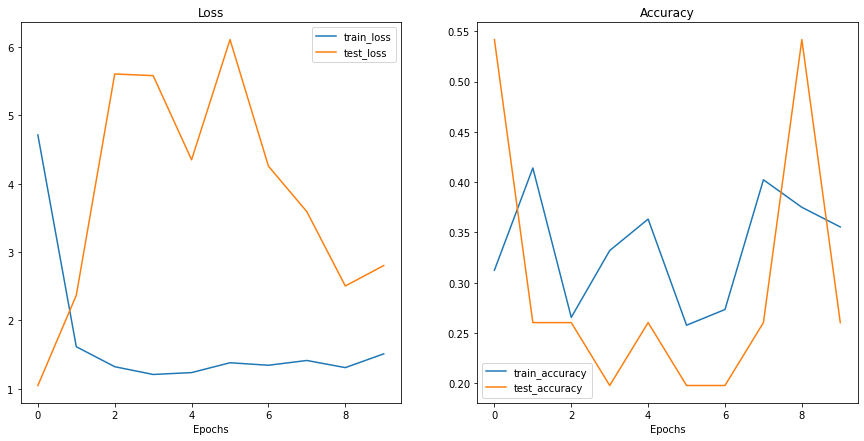

In [41]:
# plot loss curves
plot_loss_curves(results)

The ViT model performance is worse than the original paper because it requires more training examples, more epochs and a larger batch size to prevent underfitting.

### Pretrained ViT Model

In [42]:
from torchvision import models

# store best available weights from pretrained ViT-16 model
weights = models.ViT_B_16_Weights.DEFAULT
# create new ViT model initialized with the pretrained weights
vision_transformer = models.vit_b_16(weights=weights).to(device)

# freeze the parameters in the feature component of the pretrainer ViT
for params in vision_transformer.parameters():
  params.requires_grad = False

set_seeds()
# modify the classifier component of the pretrained ViT to accomodate the reduced number of classes
vision_transformer.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [43]:
# print summary of the pretrained vision transformer, only final classifier parameters should be trainable
summary(vision_transformer, input_size=(32, 3, 224, 224), col_names=['input_size', 'output_size', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 768]       False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768]       [32, 197, 768]       False
│    │    └─Enco

In [45]:
# store the original transforms used for the pretrained ViT
auto_transform = weights.transforms()
print(auto_transform)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [46]:
# create new dataloaders using this automatic transform
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_folder,
                                                                               test_dir = test_folder,
                                                                               transform=auto_transform,
                                                                               batch_size=32)

In [48]:
# set up optimizer
optimizer = torch.optim.Adam(params=vision_transformer.parameters(), lr=0.003)
# setup loss function
loss_fn = nn.CrossEntropyLoss()

In [49]:
# train pretrained model on custom dataset
set_seeds()
results = engine.train(model=vision_transformer,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5046 | train_acc: 0.8047 | test_loss: 0.2527 | test_acc: 0.9186
Epoch: 2 | train_loss: 0.1305 | train_acc: 0.9570 | test_loss: 0.1873 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.0844 | train_acc: 0.9727 | test_loss: 0.2105 | test_acc: 0.8873
Epoch: 4 | train_loss: 0.0515 | train_acc: 0.9844 | test_loss: 0.2195 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.0317 | train_acc: 0.9922 | test_loss: 0.2101 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.0280 | train_acc: 0.9961 | test_loss: 0.2023 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.0176 | train_acc: 1.0000 | test_loss: 0.2236 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.0135 | train_acc: 1.0000 | test_loss: 0.2213 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.0142 | train_acc: 1.0000 | test_loss: 0.2123 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0103 | train_acc: 1.0000 | test_loss: 0.2033 | test_acc: 0.9176


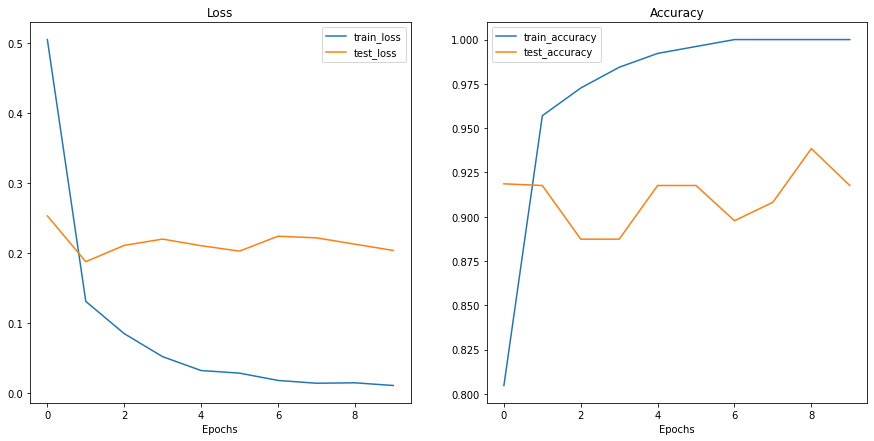

In [50]:
# plot training and test loss curves
plot_loss_curves(results)

Pretrained model performs much better on the custom dataset as it was intially trained on the much larger ImageNet dataset.

### Save ViT Model

In [61]:
from going_modular.going_modular import utils
from pathlib import Path

# save pretrained model
MODEL_PATH = 'models/'
MODEL_NAME = 'pretrained_vit.pth'
utils.save_model(model=vision_transformer, target_dir=MODEL_PATH, model_name=MODEL_NAME)

[INFO] Saving model to: models/pretrained_vit.pth


In [62]:
# show the size of the model in memory
pretrained_model_size = Path(MODEL_PATH + MODEL_NAME).stat().st_size // (1024*1024) # convert bytes to megabytes
print(f"Size of pretrained ViT model: {pretrained_model_size}MB")

Size of pretrained ViT model: 327MB


Sometimes the performance of a model may not be worth the amount of memory it takes. There is a trade off to balance.

### Prediction on a custom image

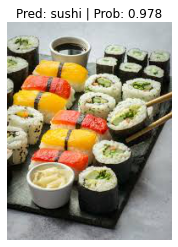

In [63]:
from going_modular.going_modular.predictions import pred_and_plot_image

# predict the class of a custom image using the pretrained ViT model
custom_image_path = 'sushi.jpeg' # ensure this image is uploaded to colab before execution
pred_and_plot_image(model=vision_transformer, image_path=custom_image_path, class_names=class_names)